# FAONet Example
This notebook demonstrates how to use the FAONet package to load, filter and analyze FAOSTAT trade data.

First, we import the necessary libraries

In [16]:
from faonet.io import load_file
from faonet.plots import plot_trade_scatter, plot_bipartite_network2, plot_degree_bar, plot_degree_comparison, plot_degree_by_rank
from faonet.filtering import filter_top_percentile
from faonet.network import build_bipartite_network, remove_zero_weight_edges
from faonet.metrics import degree_by_group
from faonet.export import export_gml
from faonet.fitting import fit_truncated_power_law


We load the file and choose the year we want to process

In [2]:
# Example filepaths
file = 'examples/Data/Green_Coffe_FAO_allyears.csv'
year = 2020
df = load_file(file, year = year)

## Clean up the market
Since we have country codes, we can colorize the interactions between countries, using color as the interaction value.

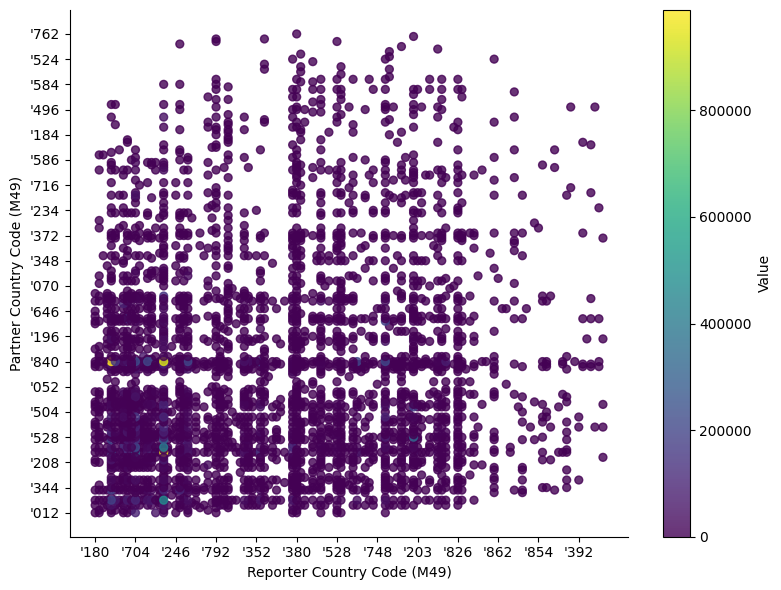

<Axes: xlabel='Reporter Country Code (M49)', ylabel='Partner Country Code (M49)'>

In [3]:
plot_trade_scatter(df)

We see that there are many very low values ​​(many purple colors) this tells us that it would be interesting to keep a percentage of the market that would allow us to better see the interactions and clean up many small interactions

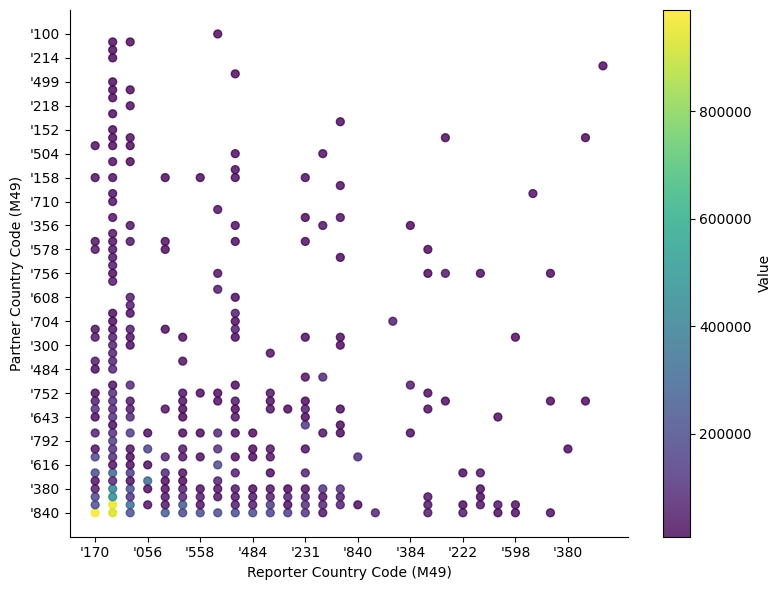

<Axes: xlabel='Reporter Country Code (M49)', ylabel='Partner Country Code (M49)'>

In [4]:
df_filtered = filter_top_percentile(df, value_column= 'Value', percentile=0.9)
plot_trade_scatter(df_filtered, step = 3)

**Now**, it seems the information is more interesting and we have left 90% of the international coffee market.

## We built the network of interactions

We built a bipartite network, with exporting and importing countries. The link width depends on the dollar value of the export.

To avoid confusion between country names, as there may be countries that act as both exporters and importers, we add '_e' to the "Reporter Countries".

In [5]:
df_filtered['Reporter Countries'] = df_filtered['Reporter Countries'] + "_e"
df_filtered.head()

,Unnamed: 0,Reporter Country Code,Reporter Country Code (M49),Reporter Countries,Partner Country Code,Partner Country Code (M49),Partner Countries,Item Code,Item Code (CPC),Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,cumsum,cumperc
36947,23426847,44,'170,Colombia_e,231,'840,United States of America,656,'01610,"Coffee, green",5922,Export value,2020,2020,1000 USD,988368.0,A,988368.0,0.053049
37650,24248428,21,'076,Brazil_e,79,'276,Germany,656,'01610,"Coffee, green",5922,Export value,2020,2020,1000 USD,965856.0,A,1954224.0,0.104889
52861,38953169,21,'076,Brazil_e,231,'840,United States of America,656,'01610,"Coffee, green",5922,Export value,2020,2020,1000 USD,929346.0,A,2883570.0,0.154770
15434,9600053,21,'076,Brazil_e,255,'056,Belgium,656,'01610,"Coffee, green",5922,Export value,2020,2020,1000 USD,467391.0,A,3350961.0,0.179856
41106,27807427,21,'076,Brazil_e,106,'380,Italy,656,'01610,"Coffee, green",5922,Export value,2020,2020,1000 USD,417441.0,A,3768402.0,0.202262


In [6]:

# Build network
G, exporters, importers = build_bipartite_network(df_filtered, 'Reporter Countries', 'Partner Countries', 'Value')
G = remove_zero_weight_edges(G)

# Export to GML
export_gml(G, 'trade_network.gml')

<Axes: title={'center': 'Bipartite Network: Exporters vs Importers in year 2020'}>

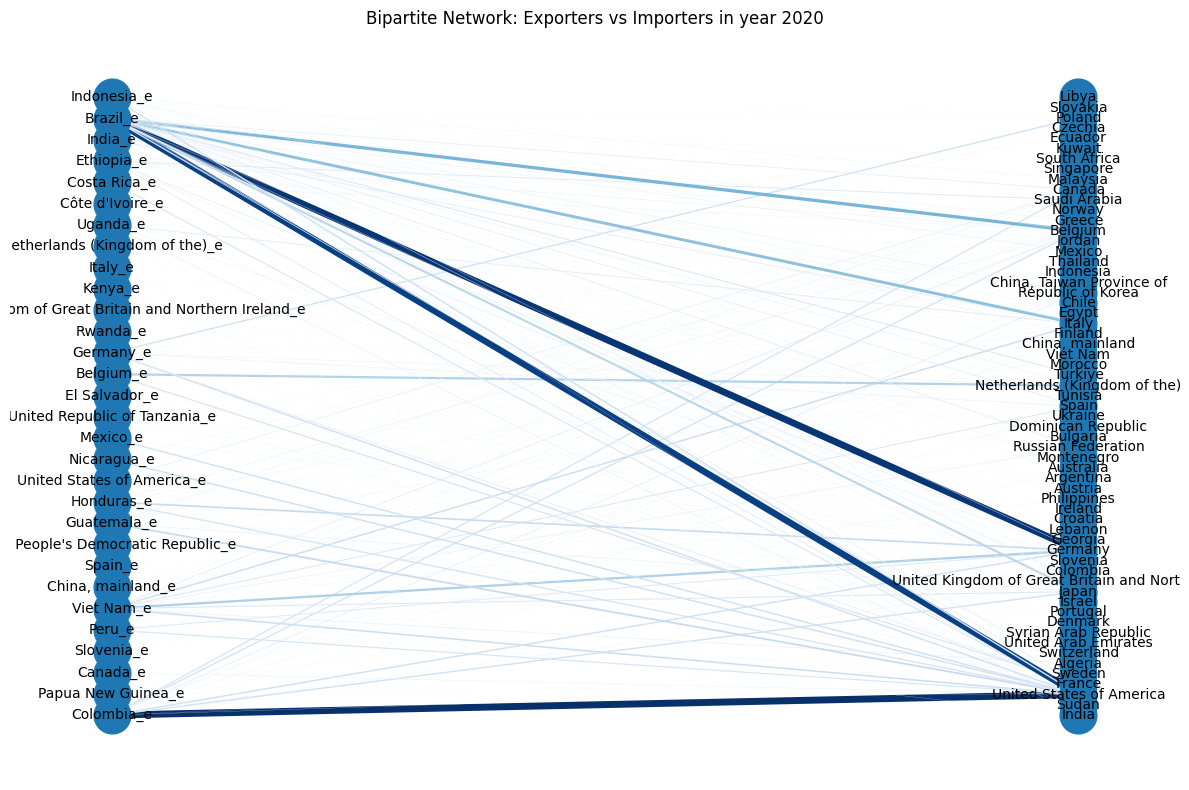

In [7]:

plot_bipartite_network2(G, group0_nodes=exporters, title="Bipartite Network: Exporters vs Importers in year 2020")

## Studying the Properties of Bipartite Networks

### Degree
The first thing usually studied is the degree of the networks. In this case, since they are bipartite, we must study the in-degree and out-degree.

Remember that the degree is the number of incoming or outgoing links, that is, the number of countries that export (out-degree) out of the number of countries that import (in-degree).

To study this, we do the following:

We calculate the degrees of exporters and importers.
We plot the histograms with the countries sorted by their degree.

In [8]:
# Compute degree
degree_export = degree_by_group(G, exporters)
print(degree_export.head())

degree_import = degree_by_group(G, importers)
print(degree_import.head())

                 Node  Degree
0          Colombia_e      21
1  Papua New Guinea_e       3
2            Canada_e       1
3          Slovenia_e       1
4              Peru_e      11
                       Node  Degree
0                     India       4
1                     Sudan       2
2  United States of America      19
3                    France      10
4                    Sweden       7


### Degree Distribution Graphs

To get an idea of ​​network behavior, one of the most interesting variables is to plot degree distributions.

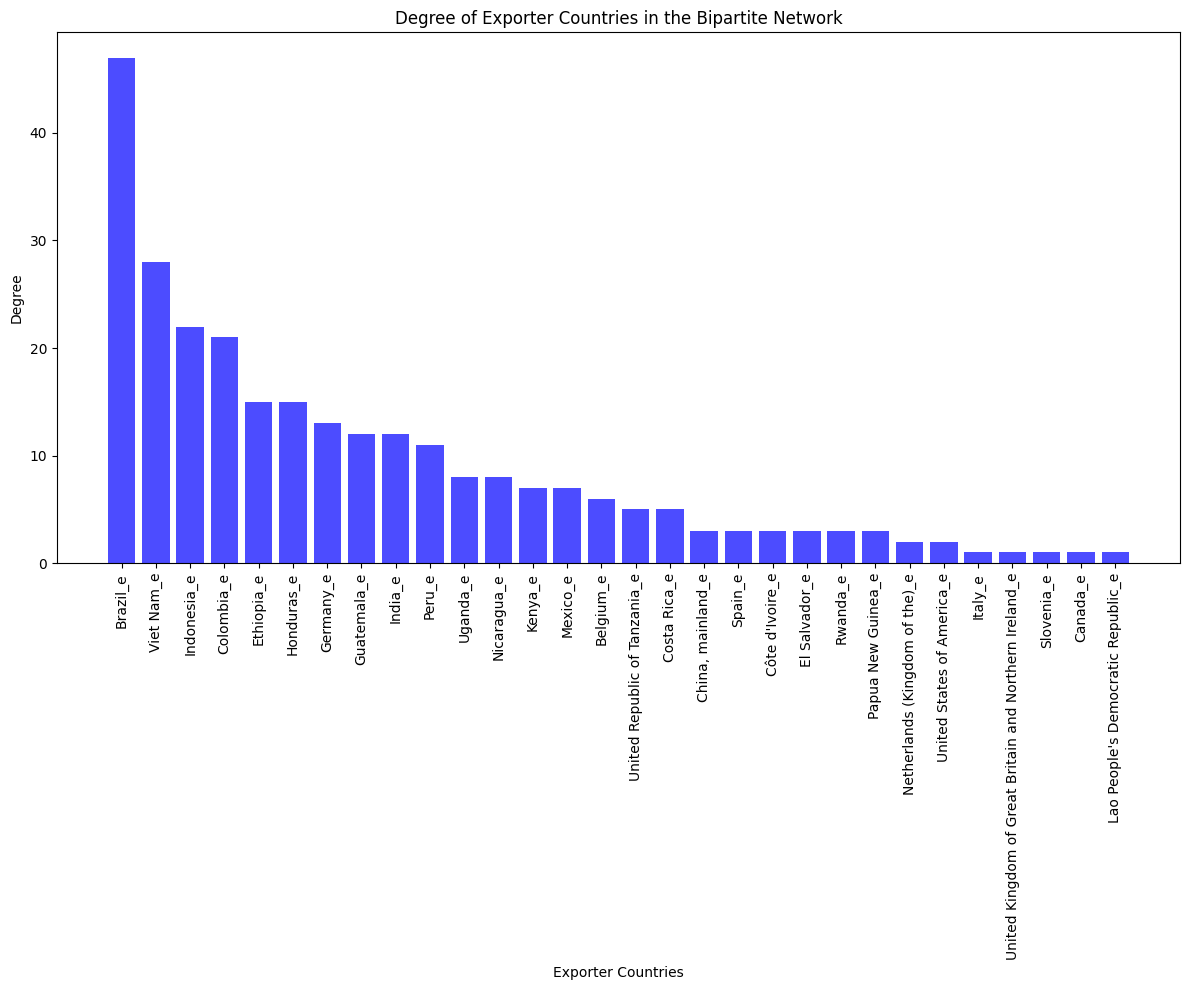

<Axes: title={'center': 'Degree of Exporter Countries in the Bipartite Network'}, xlabel='Exporter Countries', ylabel='Degree'>

In [9]:

plot_degree_bar(degree_export,
                country_col="Node",
                degree_col="Degree",
                figsize=(12, 10),
                title="Degree of Exporter Countries in the Bipartite Network",
                xlabel="Exporter Countries",
                ylabel="Degree")

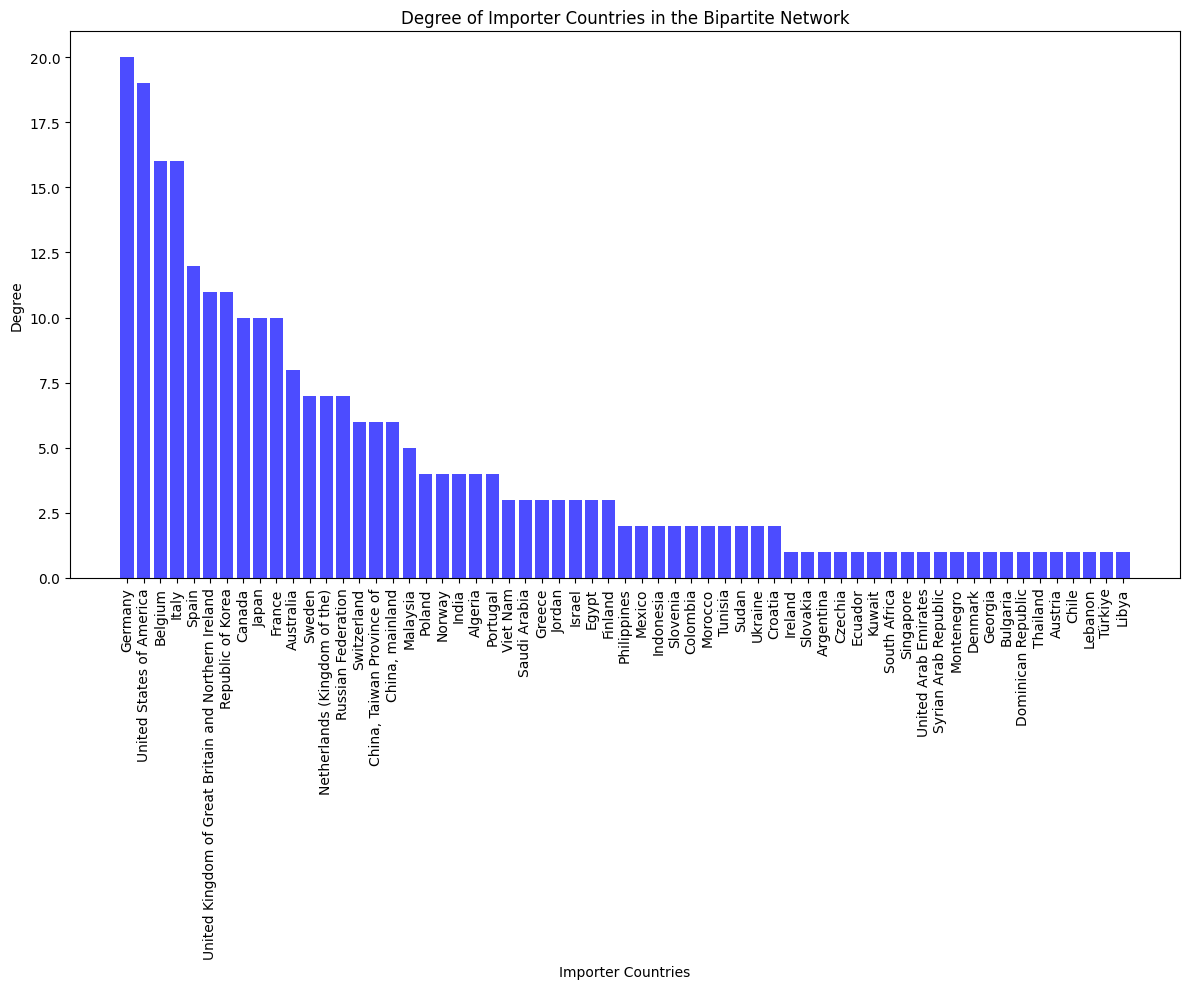

<Axes: title={'center': 'Degree of Importer Countries in the Bipartite Network'}, xlabel='Importer Countries', ylabel='Degree'>

In [10]:

plot_degree_bar(degree_import,
                country_col="Node",
                degree_col="Degree",
                figsize=(12, 10),
                title="Degree of Importer Countries in the Bipartite Network",
                xlabel="Importer Countries",
                ylabel="Degree")

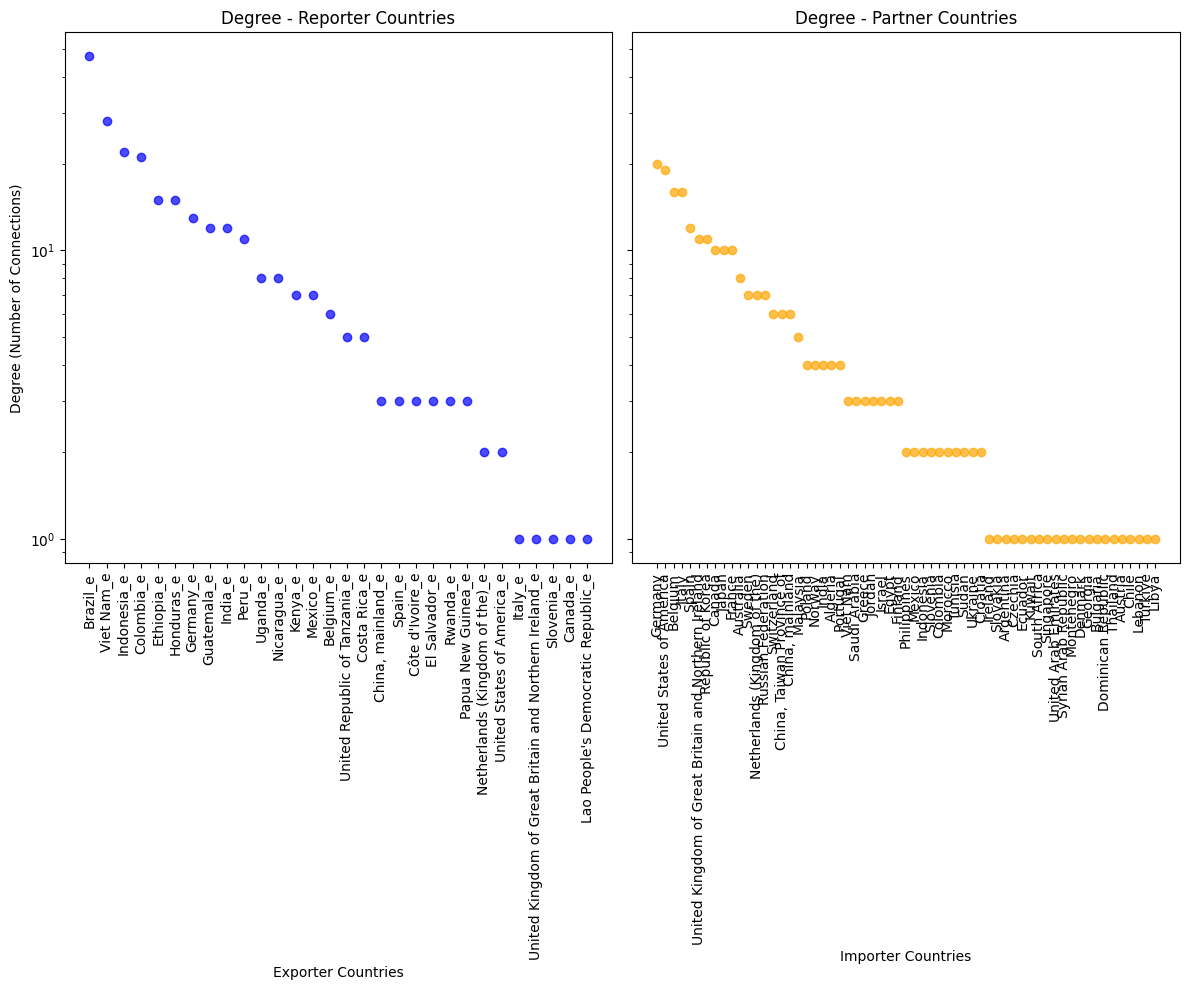

In [11]:
plot_degree_comparison(degree_export, degree_import, reporter_country_col="Node", partner_country_col="Node",use_log_scale=True)

In order to better understand the behavior of the degree distribution and to be able to compare the behaviors, we draw the degree on the y-axis and the **range** on the x-axis, that is, from the country with the highest degree to the lowest.

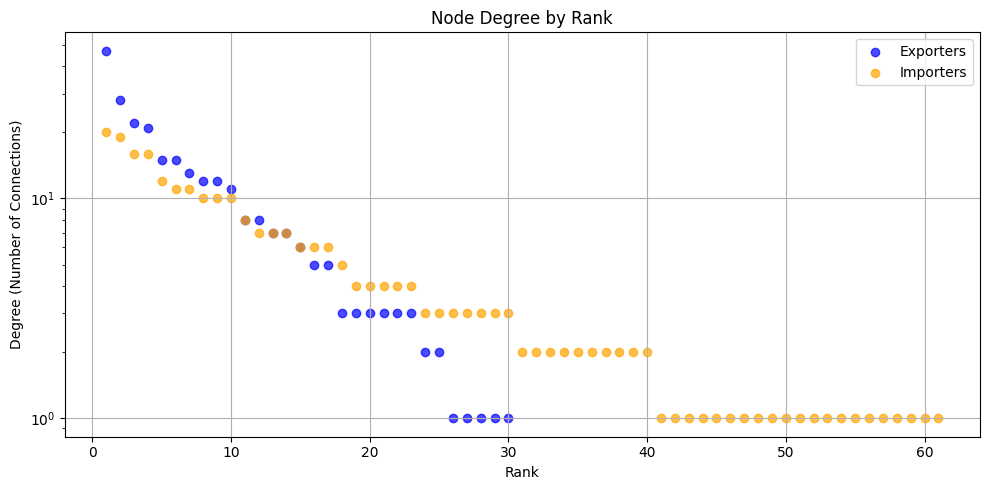

<Axes: title={'center': 'Node Degree by Rank'}, xlabel='Rank', ylabel='Degree (Number of Connections)'>

In [15]:

plot_degree_by_rank(degree_export, degree_import,use_log_x=False)

### Fitting the degree distributions.

Finally, we fit the degree distributions using a **truncated power law**, which is the curve that best fits.

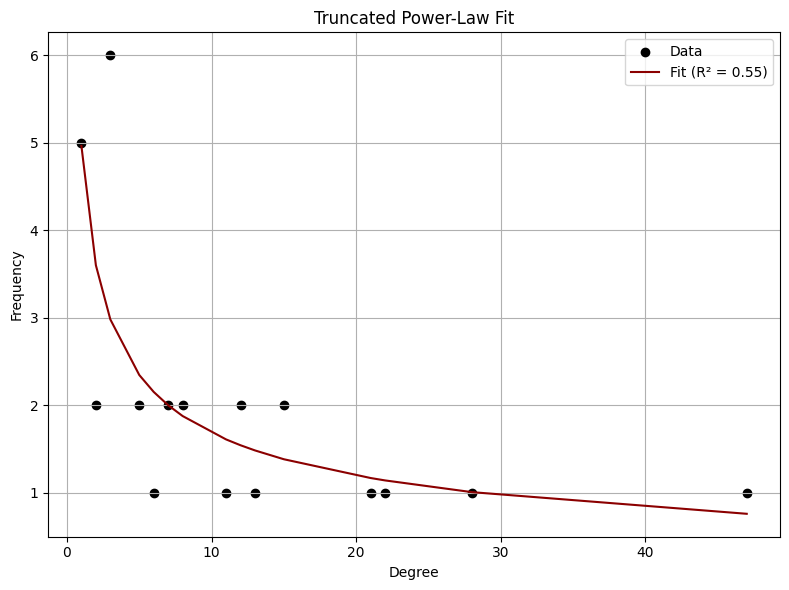

{'parameters': {'a': np.float64(4.9750656024949365), 'b': np.float64(0.45970906737613243), 'c': np.float64(439.6270971197122)}, 'r_squared': np.float64(0.5487094272889529), 'x': array([ 1,  2,  3,  5,  6,  7,  8, 11, 12, 13, 15, 21, 22, 28, 47]), 'y': array([5, 2, 6, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1]), 'fit': array([4.96376191, 3.60111386, 2.98193542, 2.34712712, 2.1535175 ,
       2.00163317, 1.87817993, 1.61136743, 1.54466735, 1.48547942,
       1.38458921, 1.17008481, 1.14272516, 1.00894334, 0.76153588])}


In [18]:
df_reporter_degrees_sorted = degree_export.sort_values(by="Degree", ascending=False)


result_exp = fit_truncated_power_law(df_reporter_degrees_sorted['Degree'])
print(result_exp)

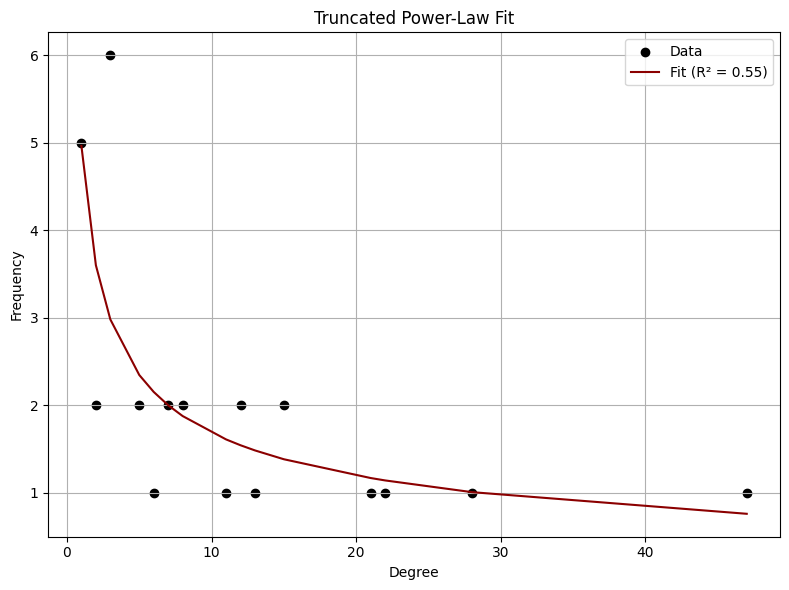

{'parameters': {'a': np.float64(4.9750656024949365), 'b': np.float64(0.45970906737613243), 'c': np.float64(439.6270971197122)}, 'r_squared': np.float64(0.5487094272889529), 'x': array([ 1,  2,  3,  5,  6,  7,  8, 11, 12, 13, 15, 21, 22, 28, 47]), 'y': array([5, 2, 6, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1]), 'fit': array([4.96376191, 3.60111386, 2.98193542, 2.34712712, 2.1535175 ,
       2.00163317, 1.87817993, 1.61136743, 1.54466735, 1.48547942,
       1.38458921, 1.17008481, 1.14272516, 1.00894334, 0.76153588])}


In [19]:
df_partner_degrees_sorted = degree_import.sort_values(by="Degree", ascending=False)

result_imp = fit_truncated_power_law(df_reporter_degrees_sorted['Degree'])
print(result_imp)